# MIMIC NLP HW3

## Setup


In [ ]:
%pip install -U pip setuptools wheel
%pip install spacy==3.7.5
%pip install gensim
%pip install transformers

import spacy
from spacy import displacy # Entity Visualizer
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.manifold import TSNE
import os

!python3 -m spacy download en_core_web_md



In [ ]:
MIMIC_3_DIR = '../mimic/mimic-iii-clinical-database-1.4'
os.chdir(MIMIC_3_DIR)

# Load diagnosis & notes data
diagnosis_df = pd.read_csv('DIAGNOSES_ICD.csv').set_index('ROW_ID')
notes_df = pd.read_csv('NOTEEVENTS.csv', low_memory=False).set_index('ROW_ID')

# Target Infections

In [ ]:
# Create a dataframe with only discharge summaries
discharge_summaries_df = notes_df.loc[notes_df['CATEGORY'] == 'Discharge summary', ['SUBJECT_ID', 'HADM_ID', 'TEXT']]

# discharge_summaries_df.head()

# Common infection codes
infection_codes = ['0380', '03810', '0382', '0383', '03842', '03843']
# Filter for only infection codes
infection_df = diagnosis_df[diagnosis_df['ICD9_CODE'].isin(infection_codes)].copy()

infection_types = {   
    "0380": "Streptococcal septicemia",
    "03810": "Staphylococcal septicemia, unspecified",
    "0382": "Pneumococcal septicemia [Streptococcus pneumoniae septicemia]",
    "0383": "Septicemia due to anaerobes",
    "03842": "Septicemia due to escherichia coli [E. coli]",
    "03843": "Septicemia due to pseudomonas",
}

# Map infection types to infection codes
infection_df['INFECTION_TYPE'] = infection_df['ICD9_CODE'].map(infection_types)

In [19]:
# Merge infection data with discharge summaries
discharge_summaries_df = pd.merge(discharge_summaries_df, infection_df, on='HADM_ID', how='inner')
# Drop duplicates
discharge_summaries_df.drop_duplicates(subset='HADM_ID', inplace=True)

discharge_summaries_df['INFECTION_TYPE'].value_counts()

INFECTION_TYPE
Septicemia due to escherichia coli [E. coli]                     455
Streptococcal septicemia                                         353
Septicemia due to pseudomonas                                    116
Septicemia due to anaerobes                                      106
Pneumococcal septicemia [Streptococcus pneumoniae septicemia]     85
Staphylococcal septicemia, unspecified                            43
Name: count, dtype: int64

# Tokenization & Entity Extraction

In [ ]:
# Load specified model (spacy/scispacy)
def load_nlp_model(model_name="en_core_web_md"): # Default spacy
    try:
        return spacy.load(model_name) # Loads specified model.
    except OSError:
        raise ValueError(f"Could not load model '{model_name}'. Make sure it is installed.")

# Tokenization function (supports both spaCy & SciSpaCy)
def tokenize_text(text, model_name="en_core_web_md"):
    nlp = load_nlp_model(model_name) # Loads specified model
    doc = nlp(text)
    
    tokens = [
        token.text.lower() # Lowercasing tokens
        for token in doc
        # Removing stopwords, punctuation, and keeping only words and numbers
        if (token.is_alpha or token.is_digit) and not token.is_stop and not token.is_punct
    ]
    
    return " ".join(tokens)

# Named Entity Recognition (NER) function
def extract_entities(text, model_name="en_core_web_md"):
    nlp = load_nlp_model(model_name)
    doc = nlp(text)
    # Extracts named entities from text using the specified NLP model
    entities = [(ent.text, ent.start_char, ent.end_char, ent.label_) for ent in doc.ents]
    # Returns a list of (text, start_char, end_char, label) tuples
    return entities


# Spacy Named Entity Recognition (NER)

In [ ]:
spacy_nlp = load_nlp_model("en_core_web_md")

# Get E. coli infection discharge summaries
ecoli_df = discharge_summaries_df[discharge_summaries_df['ICD9_CODE'] == '03842']

# Preprocess text for E. coli infection discharge summaries using spacy
ecoli_df['SPACY_PROCESSED_TEXT'] = ecoli_df['TEXT'].apply(lambda text: tokenize_text(text, "en_core_web_md"))

# Extract entities from E. coli infection df's first discharge summary
entities = extract_entities(ecoli_df.iloc[0]['SPACY_PROCESSED_TEXT'], "en_core_web_md")

# Print entities
for entity in entities:
    print(entity)

/var/folders/wd/pkw1ts416gsg2fjyp1rgznqc0000gn/T/ipykernel_96334/2235341693.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  ecoli_df['SPACY_PROCESSED_TEXT'] = ecoli_df['TEXT'].apply(lambda text: tokenize_text(text, "en_core_web_md"))


('2194', 15, 19, 'CARDINAL')
('7', 22, 23, 'CARDINAL')
('2194', 39, 43, 'CARDINAL')
('2 2', 44, 47, 'CARDINAL')
('290', 121, 124, 'CARDINAL')
('age 90', 233, 239, 'DATE')
('russian', 242, 249, 'NORP')
('ems', 319, 322, 'ORG')
('101 bp', 396, 402, 'QUANTITY')
('20 98', 406, 411, 'CARDINAL')
('4 l ns vanco 1 g', 454, 470, 'QUANTITY')
('1 g', 486, 489, 'QUANTITY')
('500 mg', 500, 506, 'QUANTITY')
('mg ativan 2 mg', 519, 533, 'PRODUCT')
('153', 582, 585, 'CARDINAL')
('10 day', 596, 602, 'DATE')
('7 day', 643, 648, 'DATE')
('90', 941, 943, 'CARDINAL')
('brady', 1008, 1013, 'PERSON')
('4', 1030, 1031, 'CARDINAL')
('sec', 1032, 1035, 'ORG')
('micu micu', 1097, 1106, 'PERSON')
('1', 1150, 1151, 'CARDINAL')
('2', 1217, 1218, 'CARDINAL')
('17', 1251, 1253, 'CARDINAL')
('micu', 1254, 1258, 'GPE')
('1', 1273, 1274, 'CARDINAL')
('2', 1315, 1316, 'CARDINAL')
('3', 1403, 1404, 'CARDINAL')
('400 mg po', 1444, 1453, 'MONEY')
('daily', 1454, 1459, 'DATE')
('7 days', 1464, 1470, 'DATE')
('8 23', 1623, 16

In [ ]:
# Visualize entities in the first discharge summary PROCESSED_TEXT
doc = spacy_nlp(ecoli_df['SPACY_PROCESSED_TEXT'].iloc[0])
displacy.render(doc, style="ent", jupyter=True)

*********************************************************************************************************************************************************************


# SciSpacy Named Entity Recognition (NER)

In [ ]:
# Load a biomedical NLP model
scispacy_nlp = load_nlp_model("en_core_sci_md")

# Preprocess text for Ecoli infection discharge summaries using scispacy
ecoli_df['SCISPACY_PROCESSED_TEXT'] = ecoli_df['TEXT'].apply(lambda text: tokenize_text(text, "en_core_sci_md"))

# Use scispacy to extract entities from the first discharge summary
entities = extract_entities(ecoli_df.iloc[0]['SCISPACY_PROCESSED_TEXT'], "en_core_sci_md")

# Print entities
for entity in entities:
    print(entity)

/var/folders/wd/pkw1ts416gsg2fjyp1rgznqc0000gn/T/ipykernel_96334/1406973440.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  ecoli_df['SCISPACY_PROCESSED_TEXT'] = ecoli_df['TEXT'].apply(lambda text: tokenize_text(text, "en_core_sci_md"))


('admission', 0, 9, 'ENTITY')
*****************
('discharge', 24, 33, 'ENTITY')
*****************
('service medicine', 48, 64, 'ENTITY')
*****************
('patient', 75, 82, 'ENTITY')
*****************
('allergies drugs', 105, 120, 'ENTITY')
*****************
('chief complaint', 125, 140, 'ENTITY')
*****************
('mental status', 149, 162, 'ENTITY')
*****************
('hypotension', 163, 174, 'ENTITY')
*****************
('surgical invasive procedure history', 181, 216, 'ENTITY')
*****************
('illness age', 225, 236, 'ENTITY')
*****************
('refractory', 242, 252, 'ENTITY')
*****************
('hodgkins lymphoma', 272, 289, 'ENTITY')
*****************
('ems', 298, 301, 'ENTITY')
*****************
('hypotensive', 339, 350, 'ENTITY')
*****************
('incontinant', 391, 402, 'ENTITY')
*****************
('stool', 403, 408, 'ENTITY')
*****************
('treated', 409, 416, 'ENTITY')
*****************
('vanco', 424, 429, 'ENTITY')
*****************
('ativan', 485, 491, 'ENTI

In [ ]:
# Visualize entities in the first discharge summary PROCESSED_TEXT
doc = scispacy_nlp(ecoli_df['SCISPACY_PROCESSED_TEXT'].iloc[0])
displacy.render(doc, style="ent", jupyter=True)

*********************************************************************************************************************************************************************


# Corpus & Word Vectors

In [ ]:
# Build a corpus of processed text
corpus = []

# Iterate through PROCESSED_TEXT on only the first 5 rows
for row in range(0, 5):
    str_tokens = []
    text = ecoli_df['SCISPACY_PROCESSED_TEXT'].iloc[row]
    print(f"Processing row {row}: {text}")
    tokens = scispacy_nlp(text).ents
    if not tokens:
        print(f"No entities found in row {row}")
    for i in range(0, len(tokens)):
        str_tokens.append(tokens[i].text)
    corpus.append(list(str_tokens))

print(corpus)


strep_df has data
Processing row 0: admission date 2194 1 7 discharge date 2194 2 2 service medicine allergies patient recorded having known allergies drugs 290 chief complaint altered mental status hypotension major surgical invasive procedure history present illness age 90 f refractory nodular sclerosing hodgkins lymphoma brought ems admitted home health care aide noted hypotensive confused ed t rectal hr 101 bp rr 20 98 incontinant stool treated 4 l ns vanco 1 g iv ceftazadime 1 g iv flagyl 500 mg iv received mg ativan 2 mg iv morphine agitation pt admitted hospital unit 153 completed course ceftazadime vancomycin urosepsis course metronidazole completed empiric treatment diff given loose stools setting elevated wbc count diff assays negative pt stabilized transferred floor care time transfer active issues poor nutritional status thrombocytopenia anemia floor pt experienced episode new afib rvr hypotension sbp 90 respiratory distress received fluid resuscitation concern syndrome pau

# Word Vectors

In [ ]:
from gensim.models import Word2Vec
word2vec_model = Word2Vec(corpus, min_count=1)
# Find the word vector for 'antibiotics'
word2vec_model.wv['antibiotics']

array([-0.00283182,  0.0003341 ,  0.00210584, -0.00930757,  0.00493962,
        0.00300007, -0.00016927, -0.00295098, -0.00769125,  0.00761941,
       -0.00875706, -0.00765256,  0.00448946, -0.00852464, -0.00318288,
       -0.00209247, -0.00187576, -0.00707326,  0.00437044,  0.00060505,
        0.00375285, -0.00115857,  0.00702125, -0.00964717,  0.00578014,
       -0.00506279,  0.0015459 , -0.00702577, -0.00269354, -0.00656069,
       -0.003216  ,  0.00979099,  0.00270684,  0.00147945, -0.00622568,
        0.00587679, -0.00813168, -0.00256503, -0.00677296, -0.00662668,
        0.00226465, -0.00330504,  0.0024074 ,  0.00384249, -0.00610504,
       -0.00177989, -0.0029077 , -0.00982303, -0.00974329,  0.00126439,
        0.00455817,  0.00010737, -0.00489825,  0.00359114,  0.00146599,
       -0.00929965,  0.00726396,  0.00770673, -0.0079496 , -0.00078658,
        0.00609485, -0.00271746, -0.00035898, -0.00421122,  0.00579314,
        0.00717151,  0.00208446, -0.00464852, -0.0021714 , -0.00

In [ ]:
word2vec_model.wv.similar_by_word('antibiotics') 

[('discharge', 0.2776538133621216),
 ('reflexes bilaterally physical exam transfer', 0.27713921666145325),
 ('lungs ctab', 0.2666809558868408),
 ('dose', 0.26522624492645264),
 ('surgeries', 0.2628735899925232),
 ('metronidazole', 0.25460758805274963),
 ('trend lfts', 0.24225164949893951),
 ('autopsy', 0.24105584621429443),
 ('gram positive cocci bacteremia', 0.2357354760169983),
 ('daily', 0.23296909034252167)]

In [ ]:

word2vec_model.wv.similarity('antibiotics', 'bacteria')


-0.011203538

# t-SNE Visualization

In [ ]:
from sklearn.cluster import KMeans
import random

def tsne_plot(model, words, preTrained=False, max_words=100, n_clusters=5):
    "Creates and TSNE model and plots it with K-Means clustering"
    labels = []
    tokens = []

    # Sample a subset of words if there are too many
    if len(words) > max_words:
        words = random.sample(words, max_words)

    for word in words:
        if preTrained:
            tokens.append(model[word])
        else:
            tokens.append(model.wv[word])
        labels.append(word)

    tokens = np.array(tokens)
    tsne_model = TSNE(perplexity=5, early_exaggeration=50, n_components=2, init='pca', n_iter=1000, random_state=23)
    new_values = tsne_model.fit_transform(tokens)

    # Perform K-Means clustering
    kmeans = KMeans(n_clusters=n_clusters, random_state=23)
    kmeans.fit(new_values)
    cluster_labels = kmeans.labels_

    x = []
    y = []
    for value in new_values:
        x.append(value[0])
        y.append(value[1])

    plt.figure(figsize=(16, 16))
    colors = plt.cm.rainbow(np.linspace(0, 1, n_clusters))
    for i in range(len(x)):
        plt.scatter(x[i], y[i], color=colors[cluster_labels[i]])
        plt.annotate(labels[i],
                     xy=(x[i], y[i]),
                     xytext=(5, 2),
                     textcoords='offset points',
                     ha='right',
                     va='bottom')
    plt.show()

/Users/jefdewitt/miniconda3/envs/new_env/lib/python3.10/site-packages/sklearn/manifold/_t_sne.py:1164: FutureWarning: 'n_iter' was renamed to 'max_iter' in version 1.5 and will be removed in 1.7.
  warnings.warn(


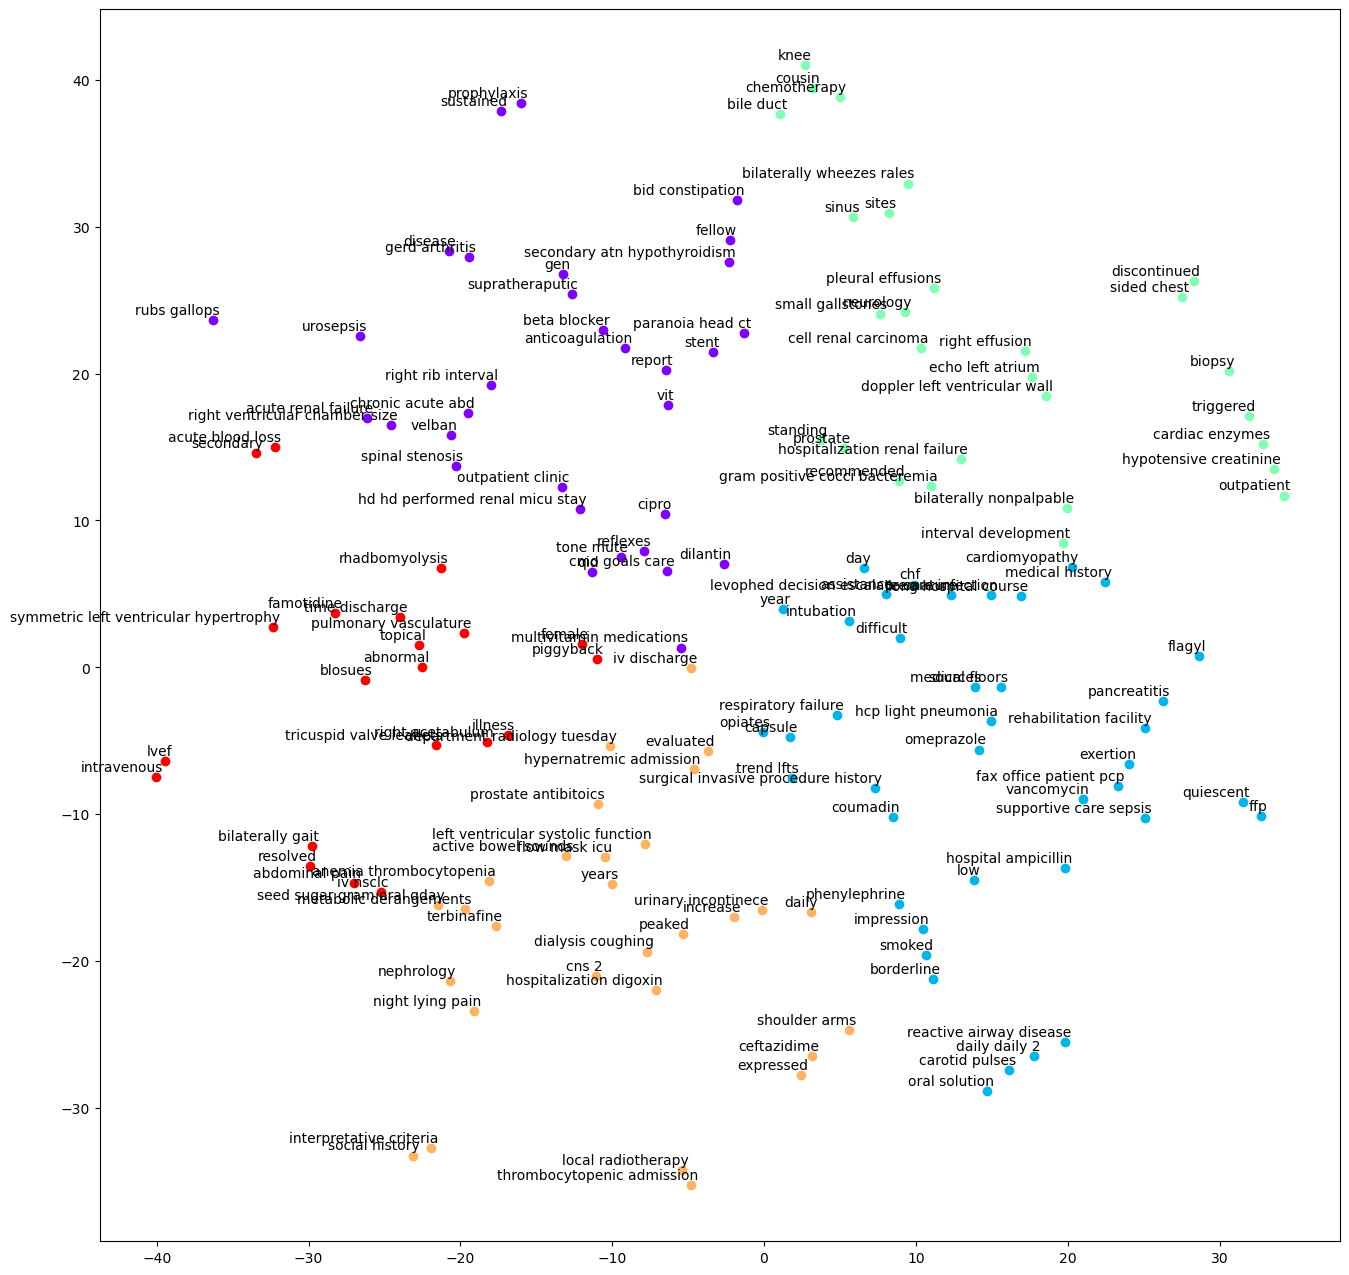

In [ ]:
# Visualize word embeddings using TSNE, indexed by the word2vec model's vocabulary
vocabs = word2vec_model.wv.index_to_key
new_v = list(vocabs)
tsne_plot(word2vec_model, new_v, preTrained=False, max_words=150)

# Topic Modeling w/ LDA

In [ ]:
import pyLDAvis
import pyLDAvis.gensim_models
from gensim import corpora
from gensim.models import LdaModel
from sklearn.feature_extraction.text import CountVectorizer
import re

def preprocess_texts(texts):
    # Remove numbers from the texts
    texts = [re.sub(r'\d+', '', text) for text in texts]
    
    # Tokenize and clean the texts
    vectorizer = CountVectorizer(stop_words='english')
    text_matrix = vectorizer.fit_transform(texts)
    tokens = [text.split() for text in texts]
    return tokens, vectorizer

def get_top_words(lda_model, num_words=5):
    top_words = {}
    for idx, topic in lda_model.print_topics(-1):
        words = topic.split(' + ')
        top_words[idx] = ', '.join([word.split('*')[1].strip('"') for word in words[:num_words]])
    return top_words

def lda_topic_modeling(texts, n_topics=5):
    tokens, vectorizer = preprocess_texts(texts)
    
    # Create a dictionary and corpus for LDA
    dictionary = corpora.Dictionary(tokens)
    corpus = [dictionary.doc2bow(token) for token in tokens]

    # Fit the LDA model
    lda_model = LdaModel(corpus, num_topics=n_topics, id2word=dictionary, random_state=23)

    # Print the top words for each topic
    top_words = get_top_words(lda_model)
    for idx, words in top_words.items():
        print(f"Topic {idx}: {words}")
        print("\n")

    # Visualize the topics
    pyLDAvis.enable_notebook()
    panel = pyLDAvis.gensim_models.prepare(lda_model, corpus, dictionary)
    return panel

texts = ecoli_df['SCISPACY_PROCESSED_TEXT'].tolist()
panel = lda_topic_modeling(texts, n_topics=5)

# Save the visualization to an HTML file
output_filepath = '/Users/jefdewitt/Documents/education/UT-Austin/courses/ai-in-healthcare/module-6/lda_visualization.html'
pyLDAvis.save_html(panel, output_filepath)
print(f"LDA visualization saved to {output_filepath}")

Topic 0: mg, po, tablet, patient, sig


Topic 1: blood, mg, tablet, po, patient


Topic 2: blood, patient, mg, po, discharge


Topic 3: mg, tablet, blood, patient, sig


Topic 4: mg, po, patient, daily, blood


LDA visualization saved to /Users/jefdewitt/Documents/education/UT-Austin/courses/ai-in-healthcare/module-6/lda_visualization.html
